# 🧠 Alzheimer's Disease Classification

🕸️ A Convolutional Neural Network (CNN) model is used here to classify brain MRIs into normal, very-mild, mild and moderate Alzheimer classes. The data in total consists of 6400 images.

Developed as part of a project work for the **UCS 1603 Introduction to Machine Learning** Course. 📖

Authors:
* Shashanka Venkatesh  - 18 5001 145
* Suraj Jain           - 18 5001 177
* Vishakan Subramanian - 18 5001 196
* Vishnu Krishnan      - 18 5001 200

**We recommend the use of a GPU Accelerator to reduce the load on the CPU and to run the notebook faster.**

### Importing the necessary libraries

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from keras.optimizers import RMSprop
from keras.losses import BinaryCrossentropy



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.12.1


### Data Pre-Processing

In [14]:
base_dir = "./kaggle_dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['NonDemented', 'Demented']


In [15]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'Demented'
            ]

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [16]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 5440 images belonging to 2 classes.


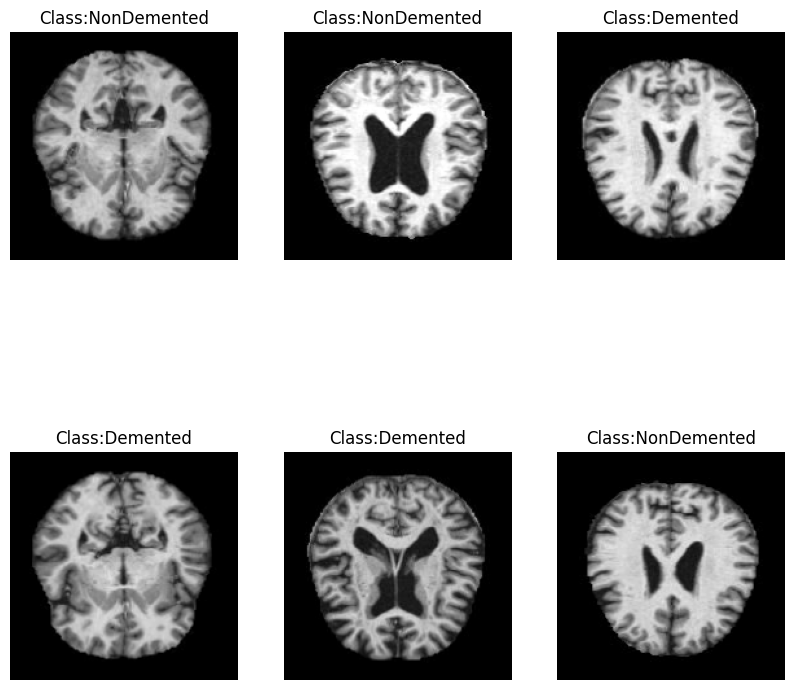

In [17]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(6):
            ax = plt.subplot(2, 3, i + 1)
            idx = randint(0, generator.samples - 1)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(6):
            ax = plt.subplot(2, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [18]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [19]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(5440, 176, 176, 3) (5440, 2)


In [20]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 1)


In [21]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Using the InceptionV3 model as a base model for the task

In [22]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

2023-09-11 18:56:52.459255: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [23]:
for layer in inception_model.layers:
    layer.trainable=False

In [24]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(1, activation='sigmoid')        
    ], name = "inception_cnn_model")

In [25]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [26]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=1)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer=RMSprop(),
                              loss=BinaryCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [27]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 25

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/25
128/128 [==============================] - 62s 453ms/step - loss: 0.8156 - acc: 0.5269 - auc: 0.5477 - f1_score: 0.6716 - val_loss: 0.6623 - val_acc: 0.6201 - val_auc: 0.6534 - val_f1_score: 0.6649 - lr: 0.0010
Epoch 2/25
128/128 [==============================] - 60s 466ms/step - loss: 0.7256 - acc: 0.5830 - auc: 0.6140 - f1_score: 0.6716 - val_loss: 0.6210 - val_acc: 0.6533 - val_auc: 0.7090 - val_f1_score: 0.6649 - lr: 0.0010
Epoch 3/25
128/128 [==============================] - 60s 473ms/step - loss: 0.6682 - acc: 0.6167 - auc: 0.6691 - f1_score: 0.6716 - val_loss: 0.6038 - val_acc: 0.6699 - val_auc: 0.7307 - val_f1_score: 0.6649 - lr: 0.0010
Epoch 4/25
128/128 [==============================] - 61s 475ms/step - loss: 0.6225 - acc: 0.6675 - auc: 0.7212 - f1_score: 0.6716 - val_loss: 0.5697 - val_acc: 0.6973 - val_auc: 0.7733 - val_f1_score: 0.6649 - lr: 0.0010
Epoch 5/25
128/128 [==============================] - 60s 470ms/step - loss: 0.5720 - acc: 0.7039 - auc: 0.7738 

### Tabulating the Results of our custom InceptionV3 model

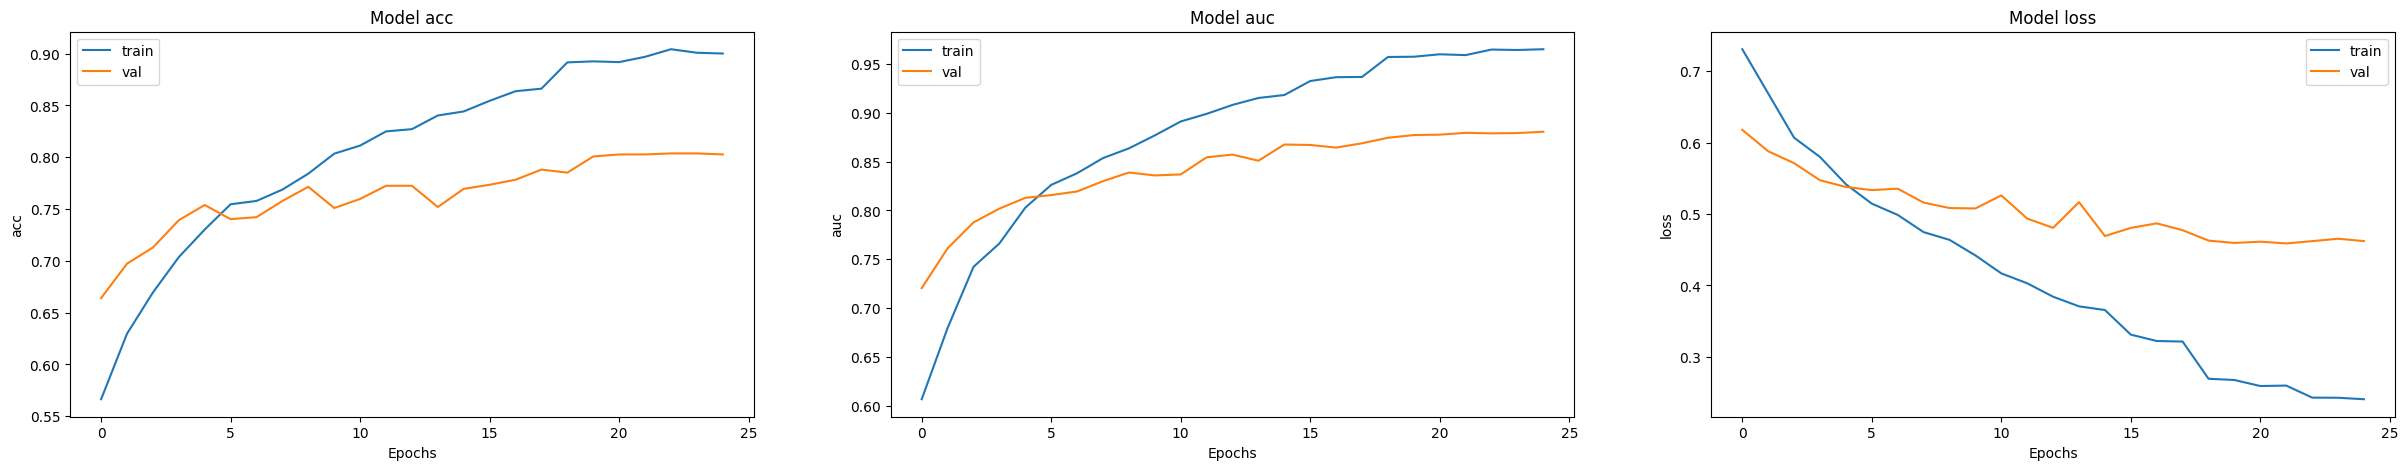

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

40/40 [==============================] - 15s 377ms/step - loss: 0.4411 - acc: 0.8055 - auc: 0.8892 - f1_score: 0.6540
Testing Accuracy: 80.55%


In [ ]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)

40/40 [==============================] - 16s 374ms/step


In [ ]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    return np.round(arr)

binary_pred_labels = np.array([roundoff(labels) for labels in pred_labels])

# Convert to one-dimensional arrays if needed
binary_test_labels = np.squeeze(test_labels)
binary_pred_labels = np.squeeze(binary_pred_labels)

print(classification_report(binary_test_labels, binary_pred_labels, target_names=CLASSES))

              precision    recall  f1-score   support

 NonDemented       0.82      0.79      0.81       658
    Demented       0.79      0.82      0.80       622

    accuracy                           0.81      1280
   macro avg       0.81      0.81      0.81      1280
weighted avg       0.81      0.81      0.81      1280



In [ ]:
# Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(binary_pred_labels, axis=1)
test_ls = np.argmax(binary_test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES,
                 yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

NameError: name 'np' is not defined

In [ ]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 100.0 %
Matthew's Correlation Coefficient: 0.0 %


In [ ]:
#Saving the model for future use

custom_inception_model_dir = work_dir + "alzheimer_inception_cnn_model"
custom_inception_model.save(custom_inception_model_dir, save_format='h5')
os.listdir(work_dir)

['NonDemented', 'Demented', 'alzheimer_inception_cnn_model']

In [ ]:
pretrained_model = tf.keras.models.load_model(custom_inception_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Using a custom CNN model for the task

**Please check out the notebook here: 
[Custom CNN Model Notebook](https://www.kaggle.com/vishakansubramanian/alzheimer-s-disease-classification-notebook)**